<h1>
<center>Comparing the Performance of popular ML algorithms</center>
</h1>

<center><font size="3">
In this notebook we structure several of the common machine learning algorithms to compare their results with our approach.
<br>
<br>
Αiming to make as fair a comparison as possible, we perform hyper-parameter optimization οn every algorithm using the validation set. 
<br>
<br>
Then knowing the best combination of hyper-parameters we train each model and evaluate the model on test set by measuring various metrics

</font></center>

## Generals

<font size="3"> 
Packages import and system configurations. 
</font>

In [1]:
#Data
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import shutil
import math
from datetime import datetime
from datetime import datetime as dt
import itertools
#Graph Counstruction
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor 
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, RBF
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

<font size="3"> 
Define necessary paths. 
</font>

In [2]:
train_path = 'io/input/base_data/train.csv'
test_path = 'io/input/base_data/test.csv'
val_path ='io/input/base_data/valid.csv'
export_path = 'io/output/exports/'
metrics_plot_path = export_path + 'metrics_plots/'

## Core Functionality

<font size="3"> 
Load data according to validation_ind (if true: return train-validation | else: return train - test) 
</font>

In [3]:
def load_data(train_path,val_path,test_path,validation_ind):
    if validation_ind:
        trainset = pd.read_csv(train_path,index_col=0)
        x_train,y_train = init_process(trainset.head(20000)) 
        valset = pd.read_csv(val_path,index_col=0)
        x_test,y_test = init_process(valset)
        x_train,x_test = scaller(x_train,x_test)
    else:
        trainset = pd.read_csv(train_path,index_col=0)
        valset = pd.read_csv(val_path,index_col=0)
        trainset = pd.concat([trainset, valset], ignore_index=True)
        x_train,y_train = init_process(trainset) 
        testset = pd.read_csv(test_path,index_col=0)
        x_test,y_test = init_process(testset)
        x_train,x_test = scaller(x_train,x_test)
    return x_train,y_train,x_test,y_test

<font size="3"> 
Split: features -  target
</font>

In [4]:
def init_process(df):
    y = df['Target']
    x = df.drop(['Target'], axis=1)
    x = x.drop(['Asset_id'], axis=1)
    return x, y

<font size="3"> 
Apply Standardization. 
</font>

In [5]:
def scaller(x_train,x_test):
    Standar_Scaller = StandardScaler()
    scalled_train_data= Standar_Scaller.fit_transform(x_train)
    scalled_test_data = Standar_Scaller.transform(x_test)
    return scalled_train_data,scalled_test_data

## Hyper-Parameters Tunig

<font size="3">
A core function that apply the evaluation procces using train & validation set:
<ol>
<li>Initialize the given regression models (SVR, DecisionTreeRegressor, XGBRegressor & more) with default hyperparameters.</li>
<li>Define the hyperparameter search spaces (ranges of values to try for each hyperparameter) for each model.</li>
<li>Loop through the three models and their corresponding hyperparameter search spaces.</li>
<li>Generate all possible combinations of hyperparameters for each model.</li>
<li>For each hyperparameter combination, fit the model on the training set, make predictions on the validation set, and calculate the MAE score.</li>
<li>Track the best hyperparameters for each model based on the lowest MAE score on the validation set.</li>
<li>Return the best hyperparameters for each model as a list of dictionaries.</li>

In [6]:
def parameter_tuning_validation(x_train, y_train, x_val, y_val):
    # Initialize the models
    svm_reg = SVR()
    tree_reg = DecisionTreeRegressor()
    xgb_reg = XGBRegressor()
    lr_reg = LinearRegression()
    knn_reg = KNeighborsRegressor()
    rf_reg = RandomForestRegressor()
    gb_reg = GradientBoostingRegressor()
    ada_reg = AdaBoostRegressor()

    # Define the hyperparameter ranges
    svm_param_grid = {'kernel': ['linear','sigmoid', 'rbf'],'C': [0.1, 10, 15],'gamma':['scale','auto']}
    tree_param_grid = {'criterion':['squared_error','friedman_mse'],'max_depth': [6,10,12], 'min_samples_split': [4, 6, 8]}
    xgb_param_grid = {'n_estimators': [6, 10, 25], 'max_depth': [1, 2, 5], 'eta':[0.1,0.3,0.5]}
    lr_param_grid = {'fit_intercept': [True, False], 'normalize': [True, False]}
    knn_param_grid = {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}
    rf_param_grid = {'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200], 'min_samples_split': [2, 4, 6]}
    gb_param_grid = {'learning_rate': [0.01, 0.1, 1.0], 'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7]}
    ada_param_grid = {'learning_rate': [0.01, 0.1, 1.0], 'n_estimators': [50, 100, 200]}

    
    models = [svm_reg, tree_reg, xgb_reg, lr_reg, knn_reg, rf_reg, gb_reg, ada_reg]
    param_grids = [svm_param_grid, tree_param_grid, xgb_param_grid, lr_param_grid,
                  knn_param_grid, rf_param_grid, gb_param_grid, ada_param_grid]

    best_params = []
    for i, model in enumerate(models):
        print('\n')
        best_mae = float('inf')
        best_mape = float('inf')
        best_params_i = {}
        # Generate all possible combinations of hyperparameters
        param_combinations = list(itertools.product(*(param_grids[i][param] for param in param_grids[i])))
        for j, params in enumerate(param_combinations):
            # Unpack the tuple of parameter values into individual arguments
            params_dict = dict(zip(param_grids[i], params))
            model.set_params(**params_dict)
            model.fit(x_train, y_train)
            y_val_pred = model.predict(x_val)
            mse = round(mean_squared_error(y_val, y_val_pred), 7)
            mae = round(mean_absolute_error(y_val, y_val_pred),7)
            r2 = round(r2_score(y_val, y_val_pred),7)
            rmse = round(np.sqrt(mean_squared_error(y_val, y_val_pred)), 7)
            param_str = ', '.join([f'{param}={value}' for param, value in params_dict.items()])
            print(f"Experiment {j+1} with {model.__class__.__name__} using {param_str} has MSE: {mse}, MAE: {mae}, R2: {r2}, RMSE: {rmse}")
            if mae < best_mae:
                best_mae = mae
                best_r2 = r2
                best_params_i = dict(zip(param_grids[i], params))
        best_params.append(best_params_i)
    return best_params

## Model Train & Test Evalaution 

<font size="3">
A core function that apply the final train and evaluation procces using train & test set:
<ol>
<li>Initialize the models with the best hyperparameters.</li>
<li>Fit each model on the training data.</li>
<li>Use the fitted models to make predictions on the test set.</li>
<li>Compute the evaluation metrics (MSE, MAE, R2, RMSE) for each model.</li>
<li>Store the results for each model in a dictionary.</li>
<li>Print the evaluation metrics for each model.</li>
<li>Return the dictionary containing the results.</li>

In [7]:
def evaluate_models(x_train, y_train, x_test, y_test, best_params):
    # Initialize the models with the best hyperparameters
    svm_reg = SVR(**best_params[0])
    tree_reg = DecisionTreeRegressor(**best_params[1])
    xgb_reg = XGBRegressor(**best_params[2])
    lr_reg = LinearRegression(**best_params[3])
    knn_reg = KNeighborsRegressor(**best_params[4])
    rf_reg = RandomForestRegressor(**best_params[5])
    gb_reg = GradientBoostingRegressor(**best_params[6])
    ada_reg = AdaBoostRegressor(**best_params[7])

    models = [svm_reg, tree_reg, xgb_reg, lr_reg, knn_reg, rf_reg, gb_reg, ada_reg]
    model_names = ['SVM', 'Decision Tree', 'XGBoost', 'Linear Regression',
                  'KNN', 'Random Forest', 'Gradient Boosting','AdaBoost']
    
    results = {}
    for i, model in enumerate(models):
        model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)
        mse = round(mean_squared_error(y_test, y_test_pred), 7)
        mae = round(mean_absolute_error(y_test, y_test_pred),7)
        r2 = round(r2_score(y_test, y_test_pred),7)
        rmse = round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 7)
        results[model_names[i]] = {'MSE': mse,'MAE': mae, 'R2': r2, 'RMSE': rmse}
        print(f"{model_names[i]} model has MSE: {mse}, MAE: {mae}, R2: {r2}, RMSE: {rmse}")
    return results

<font size="3"> 
Plot metrics on subplots for camparison purposes
</font>

In [20]:
def plot_all_metrics_train_val(metrics,metrics_plot_path):
    model_names = list(results.keys())
    mse = [results[model]['MSE'] for model in model_names]
    mae = [results[model]['MAE'] for model in model_names]
    r2 = [results[model]['R2'] for model in model_names]
    rmse = [results[model]['RMSE'] for model in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    fig, axs = plt.subplots(nrows=2, ncols=2,figsize=(12, 12))
    fig.suptitle('Comparison of Model Performance', fontsize=16)
    # Plot the first metric on the top-left subplot
    axs[0, 0].bar(x - width/2, mse, width, label='MSE')
    axs[0, 0].set_ylabel('MSE')
    axs[0, 0].set_title('MSE')
    axs[0, 0].set_xticks(x)
    axs[0, 0].set_xticklabels(model_names,rotation=90)
    #axs[0, 0].set_ylim(0,1.2)
    axs[0, 0].legend()
    # Plot the second metric on the top-right subplot
    axs[0, 1].bar(x - width/2, mae, width, label='MAE')
    axs[0, 1].set_ylabel('MAE')
    axs[0, 1].set_title('MAE')
    axs[0, 1].set_xticks(x)
    axs[0, 1].set_xticklabels(model_names,rotation=90)
    #axs[0, 1].set_ylim(0,1.2)
    axs[0, 1].legend()
    # Plot the third metric on the bottom-left subplot
    axs[1, 0].bar(x - width/2, r2, width, label='R2')
    axs[1, 0].set_ylabel('R2')
    axs[1, 0].set_title('R2')
    axs[1, 0].set_xticks(x)
    axs[1, 0].set_xticklabels(model_names,rotation=90)
    #axs[1, 0].set_ylim(0,1.2)
    axs[1, 0].legend()
    # Plot the fourth metric on the bottom-right subplot
    axs[1, 1].bar(x - width/2, rmse, width, label='RMSE')
    axs[1, 1].set_ylabel('RMSE')
    axs[1, 1].set_title('RMSE')
    axs[1, 1].set_xticks(x)
    axs[1, 1].set_xticklabels(model_names,rotation=90)
    #axs[1, 1].set_ylim(0,1.2)
    axs[1, 1].legend()
    # Adjust the spacing between subplots
    plt.tight_layout()
    # Show the plot
    plt.savefig(metrics_plot_path+'Common_Algo_Test_Metrics.pdf')
    plt.show()

## Pipeline Execution

<font size="3"> 
Hyper-Parameter tuning
</font>

In [9]:
x_train,y_train,x_val,y_val = load_data(train_path,val_path,test_path,validation_ind=True)
best_params = parameter_tuning_validation(x_train, y_train, x_val, y_val)

In [10]:
# best_params= [{'kernel': 'linear', 'C': 15, 'gamma': 'scale'},
#  {'criterion': 'squared_error', 'max_depth': 6, 'min_samples_split': 8},
#  {'n_estimators': 25, 'max_depth': 5, 'eta': 0.3},
#  {'fit_intercept': True, 'normalize': True},
#  {'n_neighbors': 7, 'weights': 'distance', 'algorithm': 'ball_tree'},
#  {'max_depth': 7, 'n_estimators': 100, 'min_samples_split': 2},
#  {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 5},
#  {'learning_rate': 1.0, 'n_estimators': 200}]

<font size="3"> 
Training and evaluation using testset
</font>

In [11]:
x_train,y_train,x_test,y_test = load_data(train_path,val_path,test_path,validation_ind=False)
results =  evaluate_models(x_train, y_train, x_test, y_test, best_params)

SVM model has MSE: 7236.1824337, MAE: 18.2342424, R2: 0.9998404, RMSE: 85.0657536
Decision Tree model has MSE: 21728.965661, MAE: 55.9871724, R2: 0.9995206, RMSE: 147.4074817
XGBoost model has MSE: 9557.6363633, MAE: 28.506349, R2: 0.9997891, RMSE: 97.7631647
Linear Regression model has MSE: 6003.8641221, MAE: 21.1049014, R2: 0.9998675, RMSE: 77.4846057


/opt/homebrew/Caskroom/miniforge/base/envs/full_ml/lib/python3.8/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(


KNN model has MSE: 2017898.5872869, MAE: 562.2954546, R2: 0.9554809, RMSE: 1420.5275736
Random Forest model has MSE: 7383.1968678, MAE: 25.1613137, R2: 0.9998371, RMSE: 85.9255309
Gradient Boosting model has MSE: 8346.0877965, MAE: 23.5466589, R2: 0.9998159, RMSE: 91.3569253
AdaBoost model has MSE: 1633955.4875454, MAE: 1203.2774908, R2: 0.9639515, RMSE: 1278.2626833


<font size="3"> 
Plot results for comparison purposes 
</font>

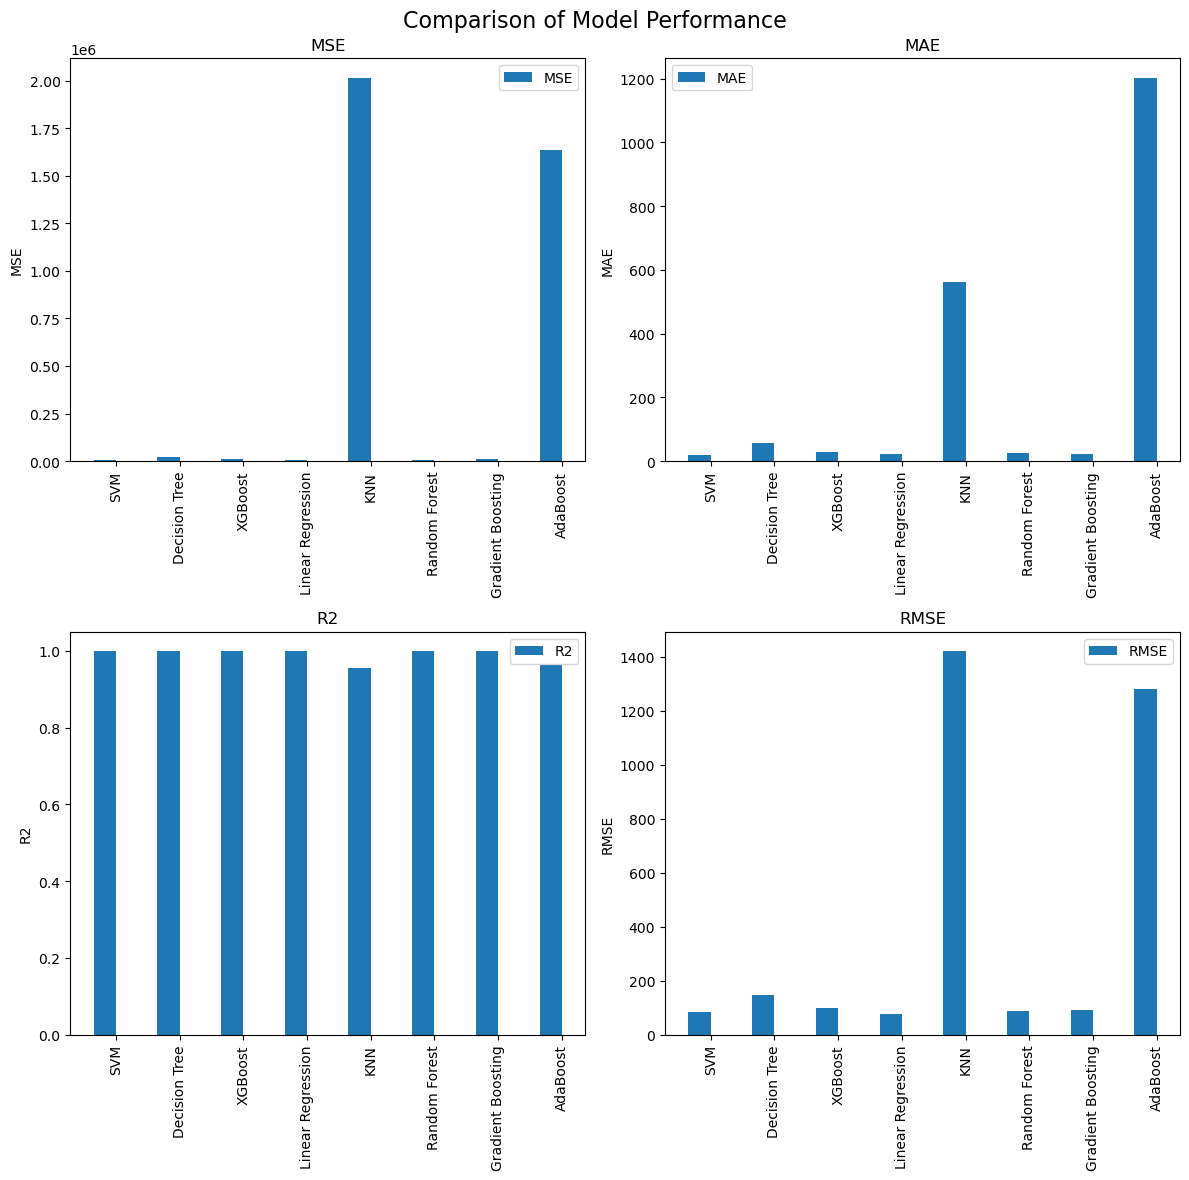

In [21]:
plot_all_metrics_train_val(results,metrics_plot_path)